In [1]:
#!pip3 install -r requirements.txt

In [2]:
qtconsole

In [1]:
import sys
import os
sys.path.insert(0, os.getcwd()+"/Utils")
sys.path.insert(0, os.getcwd()+"/Models")

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imshow
import Unet2D
import mask_functions
import getNucleusSegmentationData
import ImageGeneration
from img_utils import generate_subimages
from keras.models import Model, load_model
import Augmentor
import shutil

Using TensorFlow backend.


## All model variables are defined here

In [3]:
model_inputs = {
      "layer_count": 5,
      "starting_filter_count": 16,
      "convolution_dict": {
         "kernel_initializer": "he_normal",
         "activation": "relu",
         "kernel_size": (3, 3),
         "padding": "same",
        },
      "dropout_weight": 0.5,
      "pooling_dims": (2, 2),
      "stride_dims": (2, 2),
      "output_activation": "softmax",
      "image_height": 256,
      "image_width": 256,
      "input_channels": 1,
      "categories": 3,
      "mask_color_dict": mask_functions.original_color_dict(),
      "category_labels": ['background', 'nucleus', 'microvilli'],
      "model_optimizer": "adam",
      "loss_function": "categorical_crossentropy",
      "validation_split": 0.1,
      "epochs": 50,
      "batch_size": 16,
      "filename": 'Unet2D-trained.h5',
      "stop_after": 10,
      "image_count": 10000,
      "image_directory": os.path.join(os.getcwd(), 'Training', 'Approved_Raw_Images'),
      "overwrite_images": False,
      "ground_truth_directory": os.path.join(os.getcwd(), 'Training', 'Approved'),
      "training_directory": os.path.join(os.getcwd(), 'Training', 'Approved_Raw_Images', 'output'),
      "test_split": 0.2
    }

## Get Training Image Data

In [220]:
#this_path = os.getcwd();
#x_train, y_train, x_test = getNucleusSegmentationData.getData(model_inputs,this_path)

## Sample a subset of Data Set


In [4]:
from importlib import reload
reload(ImageGeneration)
reload(mask_functions)

directory_path = model_inputs['training_directory']
filenames = os.listdir(directory_path)
X_filenames = [os.path.join(directory_path,name) for name in filenames if name.startswith('Approved')]
Y_filenames = [os.path.join(directory_path,name) for name in filenames if name.startswith('_groundtruth_')]

X_filenames = X_filenames[0:99]
Y_filenames = Y_filenames[0:99]
X_files, Y_files = ImageGeneration.load_generated_images(X_filenames, Y_filenames, model_inputs)
X_train, X_test, Y_train, Y_test = ImageGeneration.test_train_split(X_files, Y_files, model_inputs)

Initialised with 129 image(s) found.
Output directory set to C:\users\aduen\Projects\ImageSegmentation\Training\Approved_Raw_Images\output.

129 ground truth image(s) found.


Processing <PIL.Image.Image image mode=L size=256x256 at 0x18F2C6CF908>: 100%|█| 10000/10000 [03:18<00:00, 50.44 Samples/s]


### Load the generated image permutations

{'background': array([0, 0, 0, 0]), 'nucleus': array([ 44, 160,  44, 255]), 'microvilli': array([ 31, 110, 180, 255])}


28

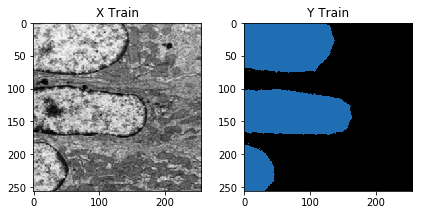

In [35]:
import random
img_id = random.randint(0,X_train.shape[0]-1)
plt.subplot(1,2,1)
xtrain0 = imshow(np.squeeze(X_train[img_id]))
plt.title('X Train')

plt.subplot(1,2,2)
ytrain0 = colorize_model_output(model_inputs,Y_train[img_id])
imshow(ytrain0)
plt.title('Y Train')

img_id

In [5]:
def colorize_model_output(model_inputs, img_array):
    full_color_dict = model_inputs['mask_color_dict']
    selected_keys = model_inputs['category_labels']
    color_dict = dict((i,full_color_dict[i]) for i in selected_keys if i in full_color_dict)
    print(color_dict)
    ytrain = img_array.reshape(
        model_inputs['image_height'],
        model_inputs['image_width'],
        model_inputs['categories'])

    mask_dict = dict((i,ytrain[:,:,idx]==255) for idx,i in enumerate(selected_keys))

    color_img = mask_functions.colorize_mask_dict(mask_dict,color_dict)
    return color_img


0

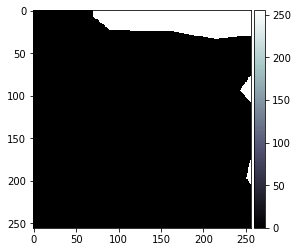

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

data = ytrain

fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

im = ax.imshow(data[:,:,2], cmap='bone')

fig.colorbar(im, cax=cax, orientation='vertical')
plt.show()


In [101]:
data[:,:,0]

(256, 256, 3)

### Split into train and test sets

## Define and Train Model

In [11]:
#model.summary()

## Get Unlabeled Test Data

In [6]:
best_model = load_model(model_inputs['filename'])
predict = best_model.predict(X_test)

## Make predictions on test data based on best model

In [11]:
best_model = load_model(model_inputs['filename'])
predict = best_model.predict(X_test)

{'background': array([0, 0, 0, 0]), 'nucleus': array([ 44, 160,  44, 255]), 'microvilli': array([ 31, 110, 180, 255])}


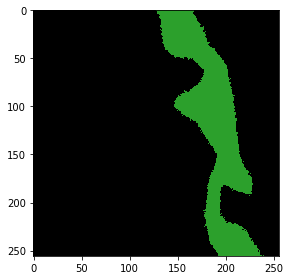

{'background': array([0, 0, 0, 0]), 'nucleus': array([ 44, 160,  44, 255]), 'microvilli': array([ 31, 110, 180, 255])}


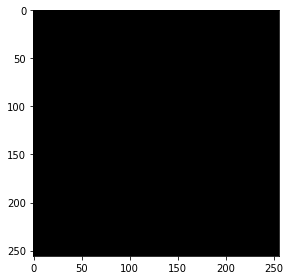

In [21]:
num_predict = predict.shape[0]
imshow(colorize_model_output(model_inputs,Y_test[12]))
plt.show()
imshow(colorize_model_output(model_inputs,predict[12]))

In [13]:
### Generate predicted image for quantification

In [18]:
predict.shape

(1000, 256, 256, 3)

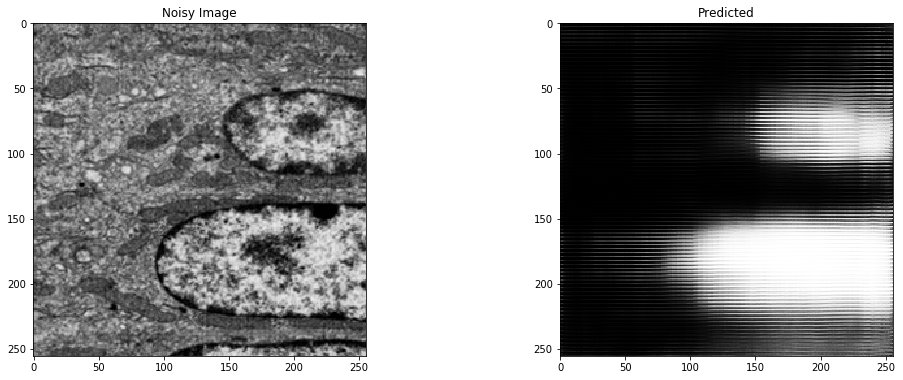

In [108]:
idx =  69
plt.subplot(1,2,1)
imshow(np.squeeze(X_test[idx]))
plt.title('Noisy Image')
plt.subplot(1,2,2)
gray = predict[idx,:,:,2]
imshow(gray)
plt.title('Predicted')
#plt.subplot(1,3,3)
#imshow(np.squeeze(y_train[idx,:,:]))
#plt.title('Ground Truth')
fig = plt.gcf()
fig.set_size_inches(15, 5)

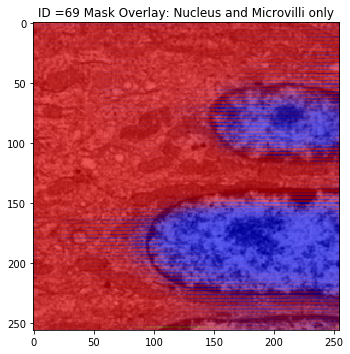

In [106]:
idx =  random.randint(0,X_test.shape[0])
imshow(np.squeeze(X_test[idx]))
gray = predict[idx,:,:,:]
imshow(gray[:,0:-1],alpha=0.6)
plt.title('ID ='+str(idx)+' Mask Overlay: Nucleus and Microvilli only')
#plt.subplot(1,3,3)
#imshow(np.squeeze(y_train[idx,:,:]))
#plt.title('Ground Truth')
fig = plt.gcf()
fig.set_size_inches(15, 5)

[False, True, True, False]

In [211]:
import numpy as np
from skimage.io import imread
img_name = 'Training/Approved/SemImage004_L7504.png'
im = imread(img_name)

In [213]:
np.unique(im.reshape(-1, im.shape[2]), axis=0)

array([[  1,   0,   0,   0],
       [ 31, 110, 180, 255],
       [ 44, 160,  44, 255],
       [214,  39,  40, 255],
       [255, 127,  14, 255],
       [255, 255, 255,   0]], dtype=uint8)

In [ ]:
import tensorflow as tf
import mask_functions
import ImageGeneration
from PIL import Image
from io import BytesIO
import base64

def make_image(imagebg,imagefg):
    """
    Convert an numpy representation image to Image protobuf.
    Copied from https://github.com/lanpa/tensorboard-pytorch/
    """
    from PIL import Image
    height, width, channel = imagebg.shape
    imagebg = Image.fromarray(imagebg)
    imagefg = Image.fromarray(imagefg)
    
    image = Image.new("RGBA", imagebg.size)
    image.paste(imagebg)
    image.paste(imagefg, (0, 0), imagefg)

    
    import io
    output = io.BytesIO()
    image.save(output, format='PNG')
    image_string = output.getvalue()
    output.close()
    return tf.Summary.Image(height=height,
                         width=width,
                         colorspace=channel,
                         encoded_image_string=image_string)


directory_path = model_inputs['training_directory']

class TensorBoardImage(keras.callbacks.Callback):
    def __init__(self, tag):
        super().__init__() 
        self.tag = tag
    
    def get_thumbnail(paths):
        bg = Image.open(paths[0])
        rgbimg = Image.new("RGB", bg.size)
        rgbimg.paste(bg)
        fg = Image.open(paths[1])
        rgbimg.paste(fg, (0, 0), fg)
        rgbimg.thumbnail((150, 150), Image.LANCZOS)
    return rgbimg
    
    def get_model_inputs():
        model_inputs = {
          "layer_count": 5,
          "starting_filter_count": 16,
          "convolution_dict": {
             "kernel_initializer": "he_normal",
             "activation": "relu",
             "kernel_size": (3, 3),
             "padding": "same",
            },
          "dropout_weight": 0.5,
          "pooling_dims": (2, 2),
          "stride_dims": (2, 2),
          "output_activation": "softmax",
          "image_height": 256,
          "image_width": 256,
          "input_channels": 1,
          "categories": 3,
          "mask_color_dict": mask_functions.original_color_dict(),
          "category_labels": ['background', 'nucleus', 'microvilli'],
          "model_optimizer": "adam",
          "loss_function": "categorical_crossentropy",
          "validation_split": 0.1,
          "epochs": 50,
          "batch_size": 16,
          "filename": 'Unet2D-trained.h5',
          "stop_after": 10,
          "image_count": 10000,
          "image_directory": os.path.join(os.getcwd(), 'Training', 'Approved_Raw_Images'),
          "overwrite_images": False,
          "ground_truth_directory": os.path.join(os.getcwd(), 'Training', 'Approved'),
          "training_directory": os.path.join(os.getcwd(), 'Training', 'Approved_Raw_Images', 'output'),
          "test_split": 0.2
        }
        return model_inputs
    
    def colorize_model_output(model_inputs, img_array):
        full_color_dict = model_inputs['mask_color_dict']
        selected_keys = model_inputs['category_labels']
        color_dict = dict((i,full_color_dict[i]) for i in selected_keys if i in full_color_dict)
        ytrain = img_array.reshape(
            model_inputs['image_height'],
            model_inputs['image_width'],
            model_inputs['categories'])

        mask_dict = dict((i,ytrain[:,:,idx]==255) for idx,i in enumerate(selected_keys))

        color_img = mask_functions.colorize_mask_dict(mask_dict,color_dict)
        return color_img
    
    def on_epoch_end(self, epoch, logs={}):
        # Load image
        params = get_model_inputs()
        filename = params['filename']
        directory_path = params['image_directory']
        filenames = os.listdir(directory_path)
        X_filenames = [os.path.join(directory_path,name) for name in filenames if name.startswith('Approved')]
        Y_filenames = [os.path.join(directory_path,name) for name in filenames if name.startswith('_groundtruth_')]

        X_filenames = X_filenames[0:99]
        Y_filenames = Y_filenames[0:99]
        X_files, Y_files = ImageGeneration.load_generated_images(X_filenames, Y_filenames, model_inputs)
        X_tr, X_te, Y_tr, Y_te = ImageGeneration.test_train_split(X_files, Y_files, model_inputs)
        
        best_model = load_model(model_inputs['filename'])
        predict = best_model.predict(X_te)
        imbg = X_te[28]
        imfg = colorize_model_output(model_inputs,predict[23])
        
        img = data.astronaut()
        # Do something to the image
        img = (255 * skimage.util.random_noise(img)).astype('uint8')

        image = make_image(imbg,imfg)
        summary = tf.Summary(value=[tf.Summary.Value(tag=self.tag, image=image)])
        writer = tf.summary.FileWriter('./logs')
        writer.add_summary(summary, epoch)
        writer.close()
        return

    tbi_callback = TensorBoardImage('Image Example')